<h1 style="text-align:center">Training CNN Neural Network for Glass Bangle Defect Detection Using Custom Model</h1>

<h3 style="text-align:right">-By Aryan Gupta</h3>

Here I tried to make my own model and see how it can perform in the dataset that I have preprocessed and feeded into the neural Network

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import os

In [1]:
!pip install opendatasets

     |████████████████████████████████| 58 kB 582 kB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a9eb65580f77e13a4ca98aef9aebb25ee7231cf195217d218aba17982c8ea6de
  Stored in directory: /Users/guptaaryan16/Library/Caches/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [2]:
import opendatasets as od
od.download(
	"https://www.kaggle.com/datasets/almique/glass-bangle-defect-detection-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryagup
Your Kaggle Key: ··········


100%|██████████| 1.31G/1.31G [00:49<00:00, 28.6MB/s]


In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
    'dataset': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(500),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = './glass-bangle-defect-detection-classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['dataset']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['dataset']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['dataset']}
class_names = image_datasets['dataset'].classes

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(class_names)

['broken', 'defect', 'good']


In [5]:
device

device(type='cuda')

In [6]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

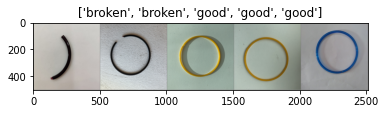

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['dataset']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
inputs.shape

torch.Size([5, 3, 500, 500])

In [9]:
# Defining the convo-net for glass-bangle detection
class ConvoNet(nn.Module):
  def __init__(self):
    super(ConvoNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 251) 
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(6*125*125,1000)
    self.fc2 = nn.Linear(1000, 3)
  def forward(self, x):
   # -> n, 3, 500, 500
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 125, 125
        x = x.view(-1, 6*125*125)            # -> n, 6*125*125
        x = F.relu(self.fc1(x))               # -> n, 1000
        x = self.fc2(x)                       # -> n, 3
        return x
model = ConvoNet().to(device)

In [10]:
# Hyperparameters
num_epochs = 2
batch_size = 5
learning_rate = 0.001

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_total_steps = len(dataloaders['dataset'])
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(dataloaders['dataset']):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 30 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [30/216], Loss: 1.0914
Epoch [1/2], Step [60/216], Loss: 1.2196
Epoch [1/2], Step [90/216], Loss: 1.0836
Epoch [1/2], Step [120/216], Loss: 0.8709
Epoch [1/2], Step [150/216], Loss: 1.0947
Epoch [1/2], Step [180/216], Loss: 1.1169
Epoch [1/2], Step [210/216], Loss: 1.0782
Epoch [2/2], Step [30/216], Loss: 1.0760
Epoch [2/2], Step [60/216], Loss: 0.8920
Epoch [2/2], Step [90/216], Loss: 1.1081
Epoch [2/2], Step [120/216], Loss: 0.8608
Epoch [2/2], Step [150/216], Loss: 1.0618
Epoch [2/2], Step [180/216], Loss: 1.3289
Epoch [2/2], Step [210/216], Loss: 1.1370


In [12]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [13]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
    'dataset': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(500),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = './glass-bangle-defect-detection-classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['dataset']}
test_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['dataset']}

In [24]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    j = 0
    for images, labels in test_loader['dataset']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
                n_class_samples[label] += 1
        j += batch_size
        if j>150: 
          break

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


Accuracy of the network: 53.54838709677419 %
